In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np
import cv2
import os
import re

<h1>Store DataSet</h1>

In [26]:
folder = '../UTKFace/'

In [3]:
def store_images_path(folder):
    df = pd.DataFrame(columns=['Path','Age'])
    for file in os.listdir(folder):
        features = file.split('_')
        df = df.append({'Path':os.path.join(folder,file),'Age':int(features[0])},ignore_index=True)
    return df

In [4]:
images = store_images_path(folder=folder)

In [21]:
images['Age'] = images['Age'].astype('Int64')

In [25]:
images.describe()

,Age
count,23708.000000
mean,33.303484
std,19.886112
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [27]:
images.to_csv('../Ages.csv',index=False)

<h1>Store Feature Matrix</h1>

In [5]:
def load_image_and_resize_vector(df):
    images = []
    for path in df['Path']:
        img = cv2.imread(path)
        resize_image = cv2.resize(img, (224,224))
        images.append(resize_image)
    return np.array(images)


In [6]:
def Compute_histogram(img):
   blue_color = cv2.calcHist([img], [0], None, [256], [0, 256])
   red_color = cv2.calcHist([img], [1], None, [256], [0, 256])
   green_color = cv2.calcHist([img], [2], None, [256], [0, 256])
   list = blue_color.flatten() 
   list = np.concatenate((list, red_color.flatten()))
   list = np.concatenate((list, green_color.flatten()))
   
   return list

In [31]:
def Compute_3x3_vector(img):
    height,width = img.shape[0],img.shape[1]
    row1 = round(height/3)
    row2 = round(height*2/3)
    row3 = height-row2
    col1 = round(width/3)
    col2 = round(width*2/3)
    col3 = width-col2

    img1 = img[:row1,:col1]
    feature_vector = Compute_histogram(img1)
    img12 = img[:row1,col1:col2]
    feature_vector = np.concatenate((feature_vector, Compute_histogram(img12)))
    img13 = img[:row1,col2:col3+col2]
    feature_vector = np.concatenate((feature_vector, Compute_histogram(img13)))

    img2 = img[row1:row2,:col1]
    feature_vector = np.concatenate((feature_vector, Compute_histogram(img2)))
    img22 = img[row1:row2,col1:col2]
    feature_vector = np.concatenate((feature_vector,Compute_histogram(img22)))

    img23 = img[row1:row2,col2:col3+col2]
    feature_vector = np.concatenate((feature_vector, Compute_histogram(img23)))


    img3 = img[row2:row3+row2,:col1]
    feature_vector = np.concatenate((feature_vector,   Compute_histogram(img3)))
    img32 = img[row2:row3+row2,col1:col2]
    feature_vector = np.concatenate((feature_vector, Compute_histogram(img32)))

    img33 = img[row2:row3+row2,col2:col3+col2]
    feature_vector = np.concatenate((feature_vector, Compute_histogram(img33)))

    return feature_vector

In [32]:
def Compute_Feature_vector(images):
    features = np.array([Compute_3x3_vector(images[0])])
    for x in range(1,len(images)):
        features = np.append(features, [Compute_3x3_vector(images[x])], axis=0)
    print(f'Shape: {features.shape}')
    return features


In [33]:
image_vector = load_image_and_resize_vector(images)

In [34]:
feature_matrix = Compute_Feature_vector(image_vector)

Shape: (23708, 6912)


In [35]:
file_name = 'Compressed_data_age'

with open(file_name, 'wb') as handle:
    pkl.dump(feature_matrix, handle, protocol=pkl.HIGHEST_PROTOCOL)

<h1>Load Dataset and feature Matrix</h1>

In [3]:
# images = pd.read_csv('../Ages.csv')
images = pd.read_csv('../../Assignment 1/task1/Data.csv')

In [4]:
# file_name = '../Compressed_data_age'
file_name = '../../Assignment 1/task1/Compressed_data'
with open(file_name, 'rb') as handle:
    feature_matrix = pkl.load(handle)
print(feature_matrix.shape)

(61, 6912)


In [7]:
X_train,X_test,y_train,y_test = train_test_split(feature_matrix,images['age'],test_size=0.2)

In [8]:
X_train.shape,X_test.shape

((48, 6912), (13, 6912))

In [13]:
reg = LinearRegression()

In [14]:
reg.fit(X_train,y_train)

LinearRegression()

In [15]:
y_pred = reg.predict(X_test)

In [16]:
mse = MSE(y_test,y_pred)
rmse = np.sqrt(mse) 

In [19]:
# model_file = 'Linear_Reg_Images_UTKFace.sav'
model_file = 'Linear_Reg_Images_my_data.sav'
pkl.dump(reg,open(model_file,'wb'))

In [20]:
# model_file = 'Linear_Reg_Images_UTKFace.sav'
model_file = 'Linear_Reg_Images_my_data.sav'
reg = pkl.load(open(model_file,'rb'))

<h1 style='text-align:center'>Model evaluation</h1>

In [21]:
print(f'Parameters: {reg.get_params()}')
print(f'Coefficient: {reg.coef_}')
print(f'Intercept: {reg.intercept_}')
print(f'Mean squared error {mse}')
print(f'Root mean squared error: {rmse}')

Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
Coefficient: [ 4.3520704e-06 -9.0717804e-05 -9.6940319e-05 ...  1.0262223e-05
 -6.5478576e-05 -1.2445201e-04]
Intercept: 23.31202507019043
Mean squared error 0.11325364048500958
Root mean squared error: 0.33653178228067787


In [31]:
X_test_array_index = np.arange(1,X_test.shape[0]+1)
X_train_array_index = np.arange(1,X_train.shape[0]+1)
X_test_array_index.shape,y_test.shape

((13,), (13,))

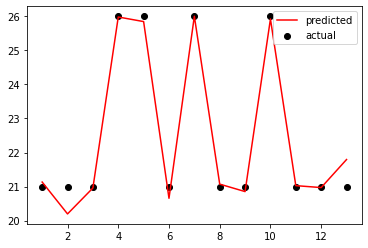

In [33]:
plt.scatter(X_test_array_index,y_test,color='black',label='actual')
plt.plot(X_test_array_index,y_pred,color='red',label='predicted')
plt.legend()
plt.plot()
plt.show()